In [4]:
import numpy as np 
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd 
from starkiller import starkiller
from glob import glob
from starkiller import spec_match, load_pbs, my_norm,downsample_spec
import pysynphot as S
import astropy.table as at
from extinction import fitzpatrick99, apply
from scipy.stats import pearsonr
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed

In [5]:
ck_files = glob('../starkiller/data/ck04_stsci/*')
svo_bp = 'GAIA/GAIA0.G'
pbs = load_pbs(svo_bp,0,'AB',SVO=True)
testfile = glob('../starkiller/data/marcs-t02/*')

In [6]:
j = 40
Rv = 3.1
model = at.Table.read(testfile[j], format='ascii')
name = testfile[j].split('/')[-1].split('.dat')[0]
if '_a' in name:
        name = name.split('_a')[0]
model = S.ArraySpectrum(wave=model['wave'].value,#lam_vac2air(model['wave'].value),
                        flux=model['flux'].value,fluxunits='flam',name=name)
test = S.ArraySpectrum(model.wave, 
                        apply(fitzpatrick99(model.wave.astype('double'),2.10*Rv,Rv),
                              model.flux),name=model.name + ' ebv=' + str(np.round(2.106,3)))
test = my_norm(test,pbs,10,name=test.name)
test = S.ArraySpectrum(wave=test.wave,#lam_vac2air(model['wave'].value),
                            flux=test.flux/np.nanmedian(test.flux),fluxunits='flam',name=test.name)#my_norm(test,pbs,10,name=test.name)


In [23]:
def _has_len(obj):
    return hasattr(obj, '__len__')

def _parallel_model_grid(model,e,Rv=3.1):
    ext = S.ArraySpectrum(model.wave, 
                        apply(fitzpatrick99(model.wave.astype('double'),e*Rv,Rv),
                              model.flux),name=model.name + ' ebv=' + str(e))
    ext = S.ArraySpectrum(wave=ext.wave,
                        flux=ext.flux/np.nanmedian(ext.flux),fluxunits='flam',name=ext.name)
    return ext


def _model_grid(model_file,target_lam=None,max_ext=4,num_cores=-1):
    extinctions = np.arange(0,max_ext,0.01)
    name = model_file.split('/')[-1].split('.dat')[0]
    model = at.Table.read(model_file, format='ascii')
    if '_a' in name:
        name = name.split('_a')[0]
    model = S.ArraySpectrum(wave=model['wave'].value,#lam_vac2air(model['wave'].value),
                            flux=model['flux'].value,fluxunits='flam',name=name)
    if target_lam is not None:
        model = S.ArraySpectrum(wave=target_lam,#lam_vac2air(model['wave'].value),
                                flux=downsample_spec(model,target_lam),fluxunits='flam',name=name)
    if num_cores == 1:
        exts = []
        for i in trange(len(extinctions)):
            exts += [_parallel_model_grid(model,extinctions[i])]
    else:
        exts = Parallel(n_jobs=num_cores)(delayed(_parallel_model_grid)(model,extinctions[i]) for i in range(len(extinctions)))
    return exts

def _parallel_cor(spec,model_fluxes,num_cores=-1):
    #coeff = Parallel(n_jobs=num_cores)(delayed(pearsonr)(spec.flux,model_fluxes[i]) for i in trange(len(model_fluxes),desc='Correlation'))
    coeff = Parallel(n_jobs=num_cores)(delayed(pearsonr)(spec.flux,model_fluxes[i]) for i in range(len(model_fluxes)))
    coeff = np.array(coeff)
    coeff[coeff<0] = 0
    coeff[~np.isfinite(coeff)] = 0
    return coeff[:,0]

def __parallel_refactoring(model):
    flux = model.flux
    ext = float(model.name.split('=')[-1])
    return flux, ext

def _match_obs_to_model(obs_spec,model_files,mags,pbs,num_cores=-1):
    if not _has_len(obs_spec):
        obs_spec = [obs_spec]
    if not _has_len(mags):
        mags = [mags]
    
        
    model_grid = []
    for i in trange(len(model_files),desc='Model grid'):
        model_grid += [_model_grid(model_files[i],target_lam=obs_spec[0].wave)]
    model_grid = np.array(model_grid).flatten()
    model_flux, model_ebv = zip(*Parallel(n_jobs=num_cores)(delayed(__parallel_refactoring)(model_grid[i]) for i in trange(len(model_grid),desc='Refactor')))
    model_spec = []
    cor = []
    ebv = []
    for i in range(len(obs_spec)):
        spec = obs_spec[i]
        cors = _parallel_cor(spec,model_flux)
        ind = np.argmax(cors)
        cor += [cors[ind]]
        model = my_norm(model_grid[ind],pbs,mags[i],name=model_grid[ind].name)
        model_spec += [model]
        ebv += [model_ebv[ind]]
    return model_spec, cor, ebv
    

In [160]:
spec, cor, e = _match_obs_to_model([test],testfile,[10],pbs)

Model grid:   0%|          | 0/247 [00:00<?, ?it/s]

Refactor:   0%|          | 0/98800 [00:00<?, ?it/s]

Correlation:   0%|          | 0/98800 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


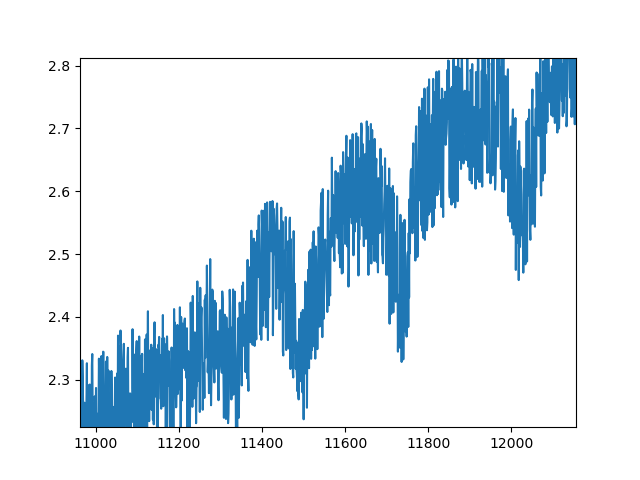

In [40]:
plt.figure()
plt.plot(test.flux + np.random.rand(len(model.flux))*0.25)

In [41]:
np.random.rand(len(model.flux)) * 

SyntaxError: invalid syntax (783029261.py, line 1)

In [14]:
test_ids = np.arange(len(ck_files))[::4]
Rv = 3.1
test_ebvs = []
models = []
for i in test_ids:
    model = at.Table.read(ck_files[i], format='ascii')
    name = testfile[j].split('/')[-1].split('.dat')[0]

    if '_a' in name:
            name = name.split('_a')[0]
    model = S.ArraySpectrum(wave=model['wave'].value,#lam_vac2air(model['wave'].value),
                            flux=model['flux'].value,fluxunits='flam',name=name)
    ebvs = np.random.rand(10) * 4
    test_ebvs += [ebvs]
    for e in ebvs:
        test = S.ArraySpectrum(model.wave, 
                                apply(fitzpatrick99(model.wave.astype('double'),e*Rv,Rv),
                                      model.flux),name=model.name + ' ebv=' + str(np.round(e,3)))
        test = my_norm(test,pbs,10,name=test.name)
        test = S.ArraySpectrum(wave=test.wave,#lam_vac2air(model['wave'].value),
                                    flux=test.flux/np.nanmedian(test.flux),fluxunits='flam',name=test.name)#my_norm(test,pbs,10,name=test.name)
        test = S.ArraySpectrum(wave=test.wave,#lam_vac2air(model['wave'].value),
                                    flux=test.flux + np.random.rand(len(test.flux))*0.1,fluxunits='flam',name=test.name)#my_norm(test,pbs,10,name=test.name)

        models += [test]

In [17]:
spec, cor, e = _match_obs_to_model(models,ck_files,np.ones_like(test_ebvs)*10,pbs)

Model grid:   0%|          | 0/39 [00:00<?, ?it/s]

Refactor:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

Correlation:   0%|          | 0/15600 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


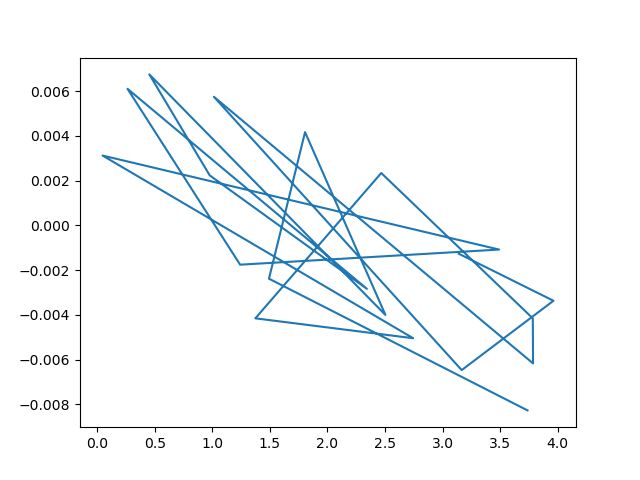

In [21]:
plt.figure()
plt.plot(test_ebvs,e-test_ebvs)

In [18]:
e

[3.73,
 1.49,
 1.81,
 2.5,
 0.46,
 0.98,
 2.34,
 0.27,
 1.24,
 3.49,
 0.05,
 2.74,
 1.37,
 2.47,
 3.7800000000000002,
 3.7800000000000002,
 1.02,
 3.16,
 3.96,
 3.14]

In [143]:
spec[0].name

'p3100_g+5.0_m0.0_t02_st_z+0.00 ebv=2.06'

In [144]:
test.name

'p3100_g+5.0_m0.0_t02_st_z+0.00 ebv=2.106'

<IPython.core.display.Javascript object>


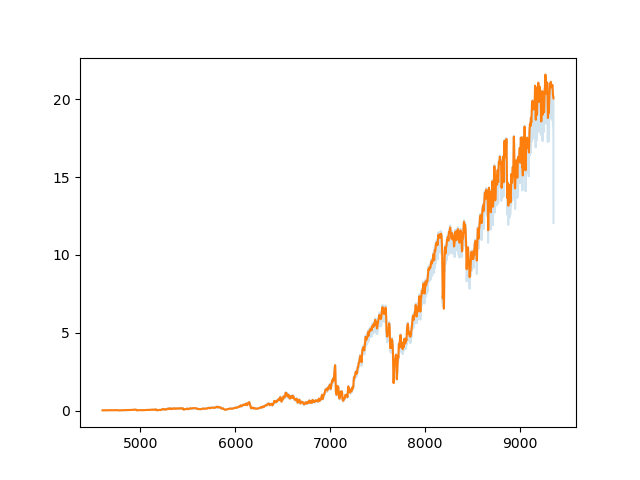

In [163]:
plt.figure()
plt.plot(spec[0].wave,spec[0].flux/np.nanmedian(spec[0].flux),alpha=0.2)
plt.plot(test.wave,test.flux)


In [12]:
a = _model_grid(ck_files[0],num_cores=-1)

test


  0%|          | 0/400 [00:00<?, ?it/s]

In [20]:
exts = []
for i in trange(len(ck_files)):
    exts += [_model_grid(ck_files[i])]
exts = np.array(exts).flatten()

  0%|          | 0/39 [00:00<?, ?it/s]

In [21]:
ar = np.array([e.flux for e in exts])
ar_ext = np.array([float(e.name.split('=')[-1]) for e in exts])

In [39]:
test.flux

array([0.02318473, 0.0232094 , 0.02323407, ..., 1.44943897, 1.44938769,
       1.44933636])

In [81]:
cors = _parallel_cor(test,ar,num_cores=8)

  0%|          | 0/15600 [00:00<?, ?it/s]

/Users/rri38/miniconda3/lib/python3.12/site-packages/joblib/parallel.py:598: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs)


In [65]:
cors[cors<0] = 0
cors[~np.isfinite(cors)] = 0
ind = np.argmax(cors)
cor = cors[ind]
spec = exts[ind]
ebv = ar_ext[ind]

In [66]:
cors[ind]

0.9999999999999952

<IPython.core.display.Javascript object>


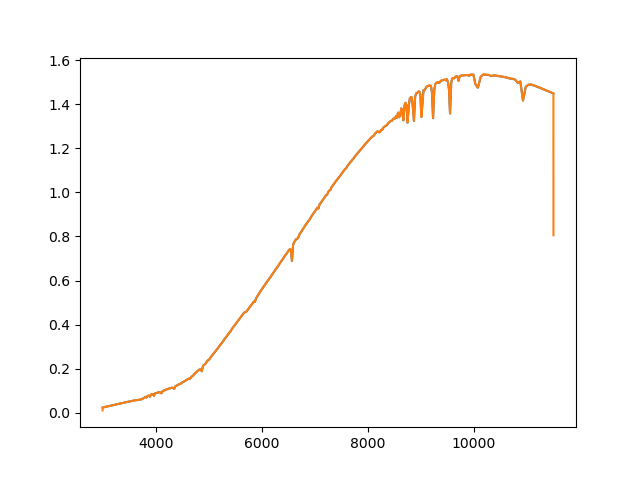

In [112]:
plt.figure()
plt.plot(test.wave,test.flux)
plt.plot(spec[0].wave,spec[0].flux)

In [68]:
test.name

'ckp00_32000_g40'

In [69]:
spec.name

'ckp00_32000_g40 ebv=2.1'

In [259]:

Rv = 3.1

cors = []
specs = []
ebvs = []
exts = []
for i in trange(len(ck_files)):

    model_file = ck_files[i]
    name = model_file.split('/')[-1].split('.dat')[0]
    model = at.Table.read(model_file, format='ascii')
    if '_a' in name:
        name = name.split('_a')[0]
    model = S.ArraySpectrum(wave=model['wave'].value,#lam_vac2air(model['wave'].value),
                            flux=model['flux'].value,fluxunits='flam',name=name)
    for e in extinctions:
        ext = S.ArraySpectrum(model.wave, 
                            apply(fitzpatrick99(model.wave.astype('double'),e*Rv,Rv),
                                  model.flux),name=model.name + ' ebv=' + str(e))
        ext = S.ArraySpectrum(wave=ext.wave,
                            flux=ext.flux/np.nanmedian(ext.flux),fluxunits='flam',name=ext.name)
        exts += [ext]


  0%|          | 0/39 [00:00<?, ?it/s]

In [260]:
ar = np.array([e.flux for e in exts])
ar_ext = np.array([float(e.name.split('=')[-1]) for e in exts])

coeff = []
for a in ar:
    coeff += [pearsonr(test.flux,a)[0]]
coeff = np.array(coeff)
coeff[coeff< 0] = 0
ind = np.argmax(coeff)
#if len(ind) > 1:
#    ind = np.argmax(coeff[ind])
cors = coeff[ind]
specs = exts[ind]
ebvs = ar_ext[ind]

0.9999999999999953

'ckp00_32000_g40 ebv=2.1'

'ckp00_38000_g40'

<IPython.core.display.Javascript object>


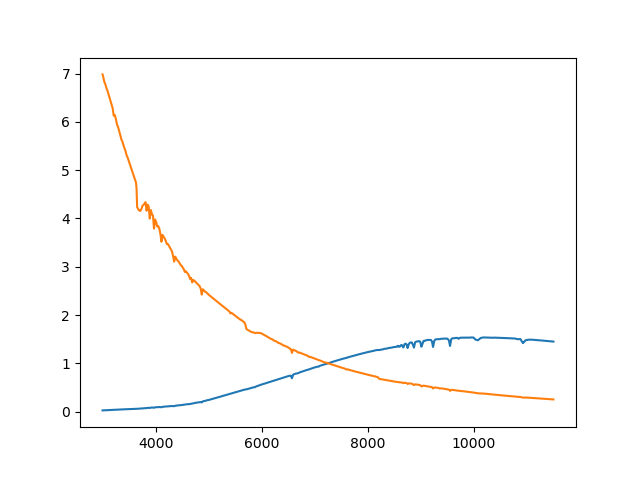

In [136]:
ar = np.array([e.flux for e in exts])
coeff = []
for a in ar:
    coeff += [pearsonr(test.flux,a)[0]]
coeff = np.array(coeff)
ind = np.argmax(coeff)
cor = coeff[ind]
spec = exts[ind]
ebv = extinctions[ind]

In [137]:
ebv

2.5500000000000003

255

In [135]:
coeff

array([-0.66967164, -0.67284943, -0.67605126, -0.67927721, -0.68252736,
       -0.68580177, -0.68910052, -0.69242366, -0.69577125, -0.69914335,
       -0.70253999, -0.70596121, -0.70940705, -0.71287753, -0.71637268,
       -0.7198925 , -0.72343701, -0.72700619, -0.73060005, -0.73421855,
       -0.73786168, -0.74152939, -0.74522164, -0.74893838, -0.75267953,
       -0.75644501, -0.76023474, -0.7640486 , -0.76788648, -0.77174824,
       -0.77563374, -0.7795428 , -0.78347524, -0.78743085, -0.79140942,
       -0.79541068, -0.79943436, -0.80348017, -0.80754776, -0.81163678,
       -0.81574684, -0.81987749, -0.82402826, -0.82819862, -0.83238801,
       -0.8365958 , -0.8408213 , -0.84506376, -0.84932236, -0.85359618,
       -0.85788423, -0.8621854 , -0.86649851, -0.87082221, -0.87515503,
       -0.87949536, -0.88384141, -0.88819119, -0.89254252, -0.89689296,
       -0.90123981, -0.90558009, -0.90991044, -0.91422717, -0.91852613,
       -0.9228027 , -0.92705173, -0.93126744, -0.93544337, -0.93

In [92]:
ar.shape

(300, 17000)

In [73]:
mags = np.ones(len(exts)) * 10
model, cors, ebvs, redshifts = spec_match(exts,mags,svo_bp,model_type='ck',num_cores=-1)

In [80]:
extinctions

array([0. , 0.1, 0.2])

In [81]:
ebvs

array([0.       , 0.       , 0.0034375])

In [82]:
model_file

'../starkiller/data/ck04_stsci/ckp00_39000_g40.dat.gz'

In [83]:
model[1].name

'ckp00_26000_g30 ebv=0.0'

<IPython.core.display.Javascript object>


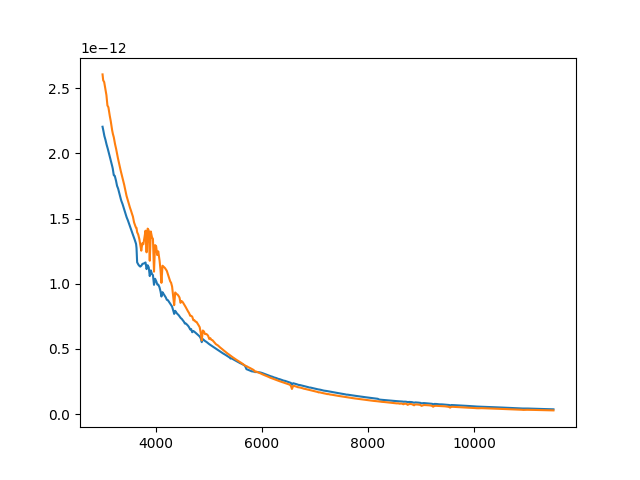

In [79]:
plt.figure()
plt.plot(exts[2].wave,exts[2].flux)
plt.plot(model[2].wave,model[2].flux)

<IPython.core.display.Javascript object>


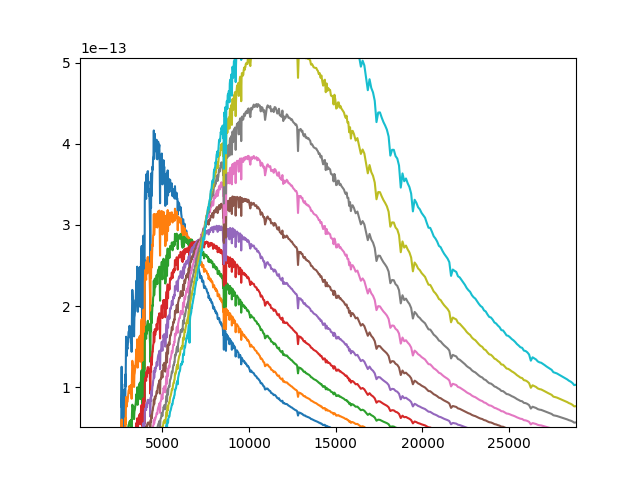

In [44]:
plt.figure()
for s in exts[::2]:
    plt.plot(s.wave,s.flux)

In [22]:
model

In [19]:
pbs

OrderedDict([('GAIA/GAIA0.G',
              (<pysynphot.spectrum.ArraySpectralElement at 0x175576ae0>,
               -21.49678066048482))])

In [15]:
model

In [ ]:
model, cors, ebvs, redshifts = spec_match(specs,10,svo_bp,model_type='ck',num_cores=-1)